<a href="https://colab.research.google.com/github/Jaesu26/Dacon-Basic/blob/main/%EC%84%9C%EC%9A%B8%EB%9E%9C%EB%93%9C%EB%A7%88%ED%81%AC-%EC%9D%B4%EB%AF%B8%EC%A7%80-%EB%B6%84%EB%A5%98-%EB%94%A5%EB%9F%AC%EB%8B%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 서울 랜드마크 이미지 분류 경진대회

## 데이터 불러오기

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import cv2
import os
import gc

from tqdm.notebook import tqdm
from glob import glob

warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive

drive.mount('/content/drive')  ## 구글코랩과 구글드라이브 연결

Mounted at /content/drive


In [3]:
%cd '/content/drive/MyDrive/Colab Notebooks/서울랜드마크-이미지-분류/Data'

/content/drive/MyDrive/Colab Notebooks/서울랜드마크-이미지-분류/Data


In [4]:
# !unzip -qq '/content/drive/MyDrive/Colab Notebooks/서울랜드마크-이미지-분류/Data/dataset.zip'

In [5]:
%cd '/content/drive/MyDrive/Colab Notebooks/서울랜드마크-이미지-분류'

/content/drive/MyDrive/Colab Notebooks/서울랜드마크-이미지-분류


- 데이터 불러오기

In [6]:
df = pd.read_csv('./Data/train.csv')
test = pd.read_csv('./Data/test.csv')
submission = pd.read_csv('./Data/sample_submission.csv')

- 하이퍼파라미터

In [7]:
MODEL_NAME = 'convmixer'
MODEL_DEFAULT_WEIGHT_PATH = f'{MODEL_NAME}_default_weight.pt' 
SAVE_PATH = './weight'
NUM_CLASSES = 10
NUM_FOLDS = 5
NUM_EPOCHS = 100
BATCH_SIZE = 16
LEARNING_RATE = 6e-4
LABEL_SMOOTHING = 0.05  ## 적절한 값을 설정하여 모델이 예측한 것을 과하게 확신하지 못하게 함
SEED = 2022

- 가중치 저장폴더

In [8]:
def create_folder(path):
    try:
        if not os.path.exists(path):
            os.makedirs(path)
    except OSError as error:
        print(error)

In [9]:
create_folder(SAVE_PATH)

- 이미지 불러오기

In [10]:
def load_images(path, format='png'):
    images = []
    images_path = path + f'/*.{format}'

    for image_path in tqdm(sorted(glob(images_path))): ## path에 들어있는 PNG 파일을 검색(1번부터 차례대로 검색해야 된다)
        image = cv2.imread(image_path)  
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, dsize=(240, 240), interpolation=cv2.INTER_LINEAR) 
        images.append(image)  
    
    images = np.array(images).astype(np.float32)
    return images

In [11]:
train_images = load_images(path='./Data/train', format='PNG')
test_images = load_images(path='./Data/test', format='PNG')

  0%|          | 0/723 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

In [12]:
train_images.shape, test_images.shape

((723, 240, 240, 3), (199, 240, 240, 3))

## 시각화

- 이미지

In [13]:
def show_random_images(images, labels, nrows=3, ncols=3):
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(nrows*2, ncols*2))
    idx_list = list(map(int, np.random.uniform(size=nrows*ncols) * images.shape[0]))
    
    for i, ax in enumerate(axs.flatten()):
        idx = idx_list[i]
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel(labels[idx])
        ax.imshow(images[idx])       
    fig.tight_layout()

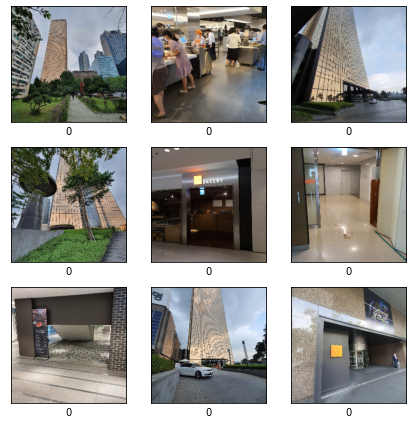

In [14]:
show_random_images(train_images[df.query('label == 0').index].astype(np.uint8), [0]*1000)

`-` 클래스 0은 외부에서 찍은 사진과 내부에서 찍은 사진으로 나뉜다

`-` 외부에서 찍은 사진은 비교적 일관적이지만 내부에서 찍은 사진은 제각각이다

`-` 적절한 라벨스무딩이 필요할 듯 하다

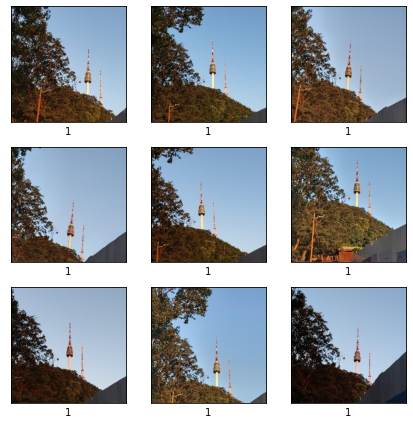

In [15]:
show_random_images(train_images[df.query('label == 1').index].astype(np.uint8), [1]*1000) 

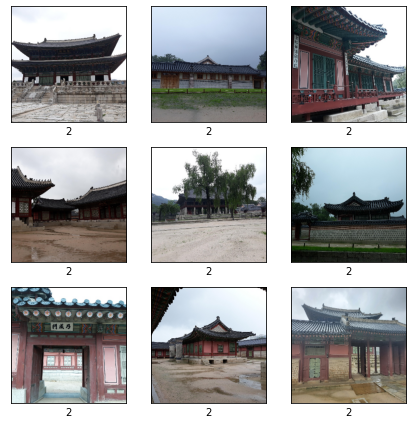

In [16]:
show_random_images(train_images[df.query('label == 2').index].astype(np.uint8), [2]*1000)

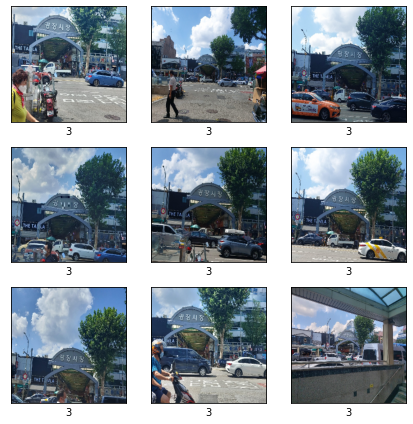

In [17]:
show_random_images(train_images[df.query('label == 3').index].astype(np.uint8), [3]*1000)

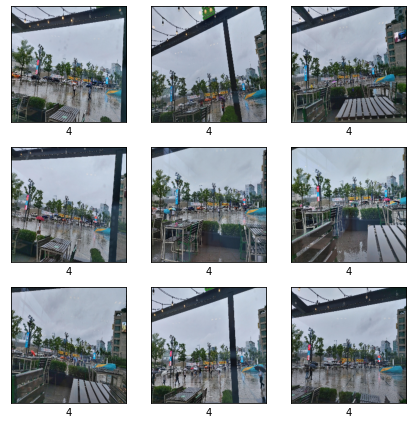

In [18]:
show_random_images(train_images[df.query('label == 4').index].astype(np.uint8), [4]*1000)

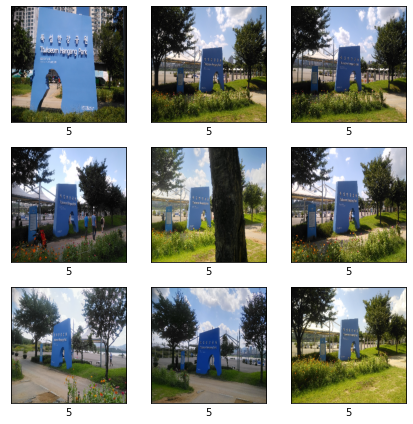

In [19]:
show_random_images(train_images[df.query('label == 5').index].astype(np.uint8), [5]*1000)

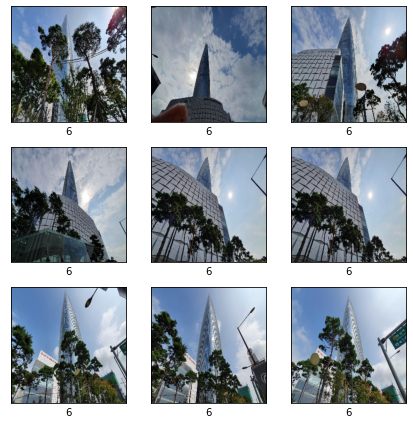

In [20]:
show_random_images(train_images[df.query('label == 6').index].astype(np.uint8), [6]*1000)

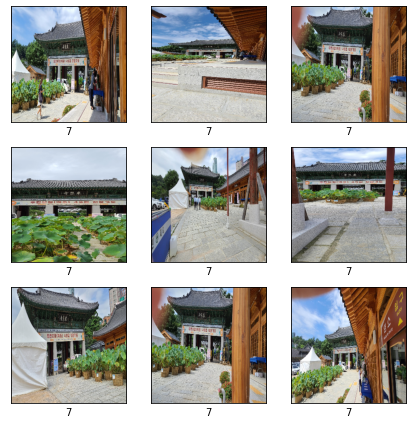

In [21]:
show_random_images(train_images[df.query('label == 7').index].astype(np.uint8), [7]*1000)

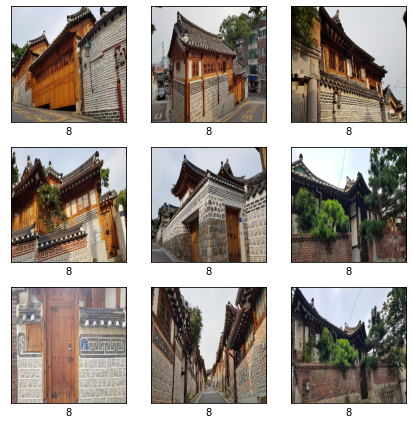

In [22]:
show_random_images(train_images[df.query('label == 8').index].astype(np.uint8), [8]*1000)

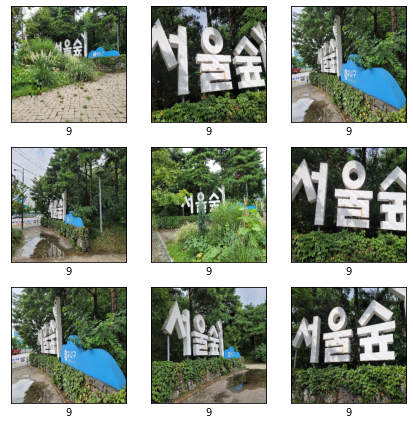

In [23]:
show_random_images(train_images[df.query('label == 9').index].astype(np.uint8), [9]*1000)

- 라벨

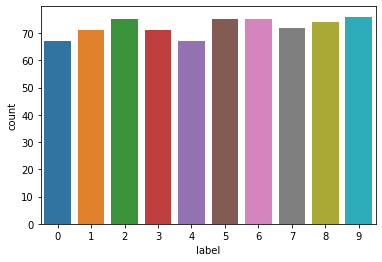

In [24]:
sns.countplot(data=df, x='label')

`-` 라벨별 개수는 비슷하다

## 모델 학습 준비

In [25]:
!pip install albumentations==1.2.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'현재 device는 {device}입니다')

현재 device는 cuda입니다


In [28]:
## 정확도 계산
def accuracy(true, pred):
    return sum(true == pred) / len(true)

In [29]:
def seed_everything(seed=22):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [30]:
def clear_gpu():
    gc.collect()
    torch.cuda.empty_cache()

- 데이터 셋과 데이터 로더

In [31]:
class CustomDataset(Dataset):
    def __init__(self, images, labels=None, transforms=None):
        self.images = images
        self.labels = labels
        self.transforms = transforms
    
    def __getitem__(self, idx):
        image = self.images[idx]    
        if self.transforms is not None:
            image = self.transforms(image=image)['image']  ## albumentations 사용

        if self.labels is not None:
            label = self.labels[idx]
            return image, label
        return image  ## test는 라벨이 없다
    
    def __len__(self):
        return len(self.images)  

In [32]:
def get_dataloader(X, y=None, transforms=None, shuffle_dataloader=True):
    dataset = CustomDataset(X, y, transforms)    
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=shuffle_dataloader)
    return dataloader

- 데이터 변환

In [33]:
RGB_MEAN = [np.mean((train_images[..., i])) / 255 for i in range(3)] 
RGB_STD = [np.std(train_images[..., i]) / 255 for i in range(3)]  

In [34]:
## 데이터 변환 방식을 정의 (Agumentation)
def get_transforms(train_mode=True):
    transforms = A.Compose([
        A.Resize(224, 224),
        A.Normalize(mean=RGB_MEAN, std=RGB_STD), 
        ToTensorV2()  ## (H X W X C) 차원의 numpy array를 (C X H X W) 차원의 torch.Tensor로 변환 
    ])
    
    if train_mode:
        transforms = A.Compose([
            A.CenterCrop(224, 224),   
            A.Perspective(scale=0.2, p=0.5),
            A.Rotate(limit=25, p=0.5),  
            A.Cutout(num_holes=8, max_h_size=8, max_w_size=8, p=0.5),
            A.Normalize(mean=RGB_MEAN, std=RGB_STD), 
            ToTensorV2()  ## (H X W X C) 차원의 numpy array를 (C X H X W) 차원의 torch.Tensor로 변환  
        ])

    return transforms  ## 데이터 변환 방식을 반환

`-` 색을 바꾸면 클래스 0과 6을 구분하기 힘들다

`-` 그래서 색을 변형시키는 변환은 사용하지 않겠다

In [35]:
target = df['label'].values

- 딥러닝 모델

In [36]:
## Copyright (c) 2021 Author(s) of ICLR 2022 Submission "Patches Are All You Need?"
## 코드: https://github.com/locuslab/convmixer/blob/main/convmixer.py
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x):
        return self.fn(x) + x

def ConvMixer(dim, depth, kernel_size=3, patch_size=3, n_classes=10):
    return nn.Sequential(
        nn.Conv2d(3, dim, kernel_size=patch_size, stride=patch_size),
        nn.GELU(),
        nn.BatchNorm2d(dim),
        *[nn.Sequential(
                Residual(nn.Sequential(
                    nn.Conv2d(dim, dim, kernel_size, groups=dim, padding='same'),
                    nn.GELU(),
                    nn.BatchNorm2d(dim)
                )),
                nn.Conv2d(dim, dim, kernel_size=1),
                nn.GELU(),
                nn.BatchNorm2d(dim)
        ) for i in range(depth)],
        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Flatten(),
        nn.Linear(dim, n_classes)
    )

- 가중치 초기화

In [37]:
## layer 가중치 초기화
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        y = m.in_features
        nn.init.normal_(m.weight.data, 0.0, np.sqrt(2 / y))
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

- 조기 중단

In [38]:
## Copyright (c) 2018 Bjarte Mehus Sunde
## 코드 참고: https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='./weight', model_name='', current_fold=1):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 에폭
                            Default: 7

            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
                            
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0

            path (str): checkpoint 공통 저장 경로
                            Default: './weight'

            model_name (str): 학습시킬 모델의 이름
                            Default: ''

            current__fold (int): 현재 학습을 진행하는 fold의 순서
                            Default: 1
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.val_acc = 0
        self.delta = delta
        self.path = path
        self.model_name = model_name
        self.current_fold = current_fold

    def __call__(self, model, val_loss, val_acc):
        score = -val_loss  ## val_loss는 작을수록 좋다 ## score는 0에 가까울수록 좋다

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, val_acc, model)  
        elif score < self.best_score + self.delta: 
            self.counter += 1 
            if self.counter >= self.patience:  ## 만약 loss가 개선되지 않은 스탭이 patience보다 크거나 같아진다면 조기중단
                self.early_stop = True
        else: 
            self.best_score = score 
            self.save_checkpoint(val_loss, val_acc, model) 
            self.counter = 0  ## loss가 개선되었으므로 0으로 초기화

    def save_checkpoint(self, val_loss, val_acc, model):
        """validation loss가 감소하면 모델을 저장"""
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.5f} -> {val_loss:.5f})  Saving model ...')
        torch.save(model.state_dict(), self.path + f'/{self.model_name}_best_{self.current_fold}.pt') 
        self.val_loss_min = val_loss  ## 모델이 더 좋게 갱신되었으므로 이때의 valid loss를 기준치로 변경
        self.val_acc = val_acc  ## 이때의 valid accuracy도 변경해준다

    def set_fold(self, current_fold):
        self.current_fold = current_fold

    def reset_score(self):
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.val_acc = 0

## 모델 K겹 교차검증

In [39]:
from sklearn.model_selection import StratifiedKFold

- Kfold와 손실 함수

In [40]:
skfold = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=SEED)
loss_fn = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)

- early stopping

In [59]:
early_stopping = EarlyStopping(patience=20,
                               verbose=False,
                               path=SAVE_PATH,
                               model_name=MODEL_NAME,
                               current_fold=1)  ## patience 횟수 에폭후에도 valid loss가 작아지지 않으면 조기 중단

- 모델 교차검증 관련 함수

In [49]:
def train(model, dataloader, optimizer, loss_fn, scheduler=None):
    """dataloader의 데이터를 사용하여 학습된 모델과 평균 배치 훈련 오차를 반환"""  
    train_loss = 0.0  ## mini-batch 평균 훈련 오차 
    model = model.to(device)
    model.train()

    for X, y in dataloader:  ## 미니 배치 단위로 꺼내온다, X는 미니 배치, y는 레이블
        X, y = X.to(device), y.to(device)
        y_hat = model(X)
        loss = loss_fn(y_hat, y)  
        optimizer.zero_grad()  ## 그래디언트 초기화
        loss.backward()   ## 미분
        optimizer.step()  ## 업데이트
        train_loss += (loss.item() / len(dataloader)) 
  
    ## 에폭마다 학습률 조절
    if scheduler is not None:
        scheduler.step()

    return model, train_loss

In [50]:
def evaluate(model, dataloader, loss_fn):
    """dataloader의 데이터를 사용하여 평균 배치 검증 오차와 정확도를 반환"""
    valid_acc, valid_loss = 0.0, 0.0  ## mini-batch 평균 검증 오차와 정확도 
    model = model.to(device)
    model.eval()  

    with torch.no_grad():  ## 역전파를 계산할 필요가 없으니까
        for X, y in dataloader:  ## 미니 배치 단위로 꺼내온다, X는 미니 배치, y는 레이블
            X, y = X.to(device), y.to(device)
            y_hat = model(X)
            loss = loss_fn(y_hat, y)  
            acc = accuracy(y.cpu().data.numpy(), y_hat.cpu().data.numpy().argmax(-1))       
            valid_acc += (acc * len(y) / len(dataloader.dataset))  ## 각 배치마다 정확도(정답 개수 / 전체 개수)
            valid_loss += loss.item() / len(dataloader)    

    return valid_loss, valid_acc

In [83]:
def show_loss_plot(train_losses, valid_losses):
    assert len(train_losses) == len(valid_losses)
    num_folds = len(train_losses)
    ncols = 3
    nrows = 1 + (num_folds - 1)//ncols
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*4)) 

    ## 폴드마다 에폭에 따른 train loss와 valid loss의 변화를 시각화
    for fold, (ax, train_loss, valid_loss) in enumerate(zip(axs.flatten(), train_losses, valid_losses), start=1):
        assert len(train_loss) == len(valid_loss) 
        if fold > num_folds:
            break

        num_epochs = len(train_loss)
        ax.set_title(f'{fold} Fold')
        ax.plot(range(1, num_epochs+1), train_loss, label='Train')
        ax.plot(range(1, num_epochs+1), valid_loss, label='Valid')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend()

    fig.suptitle('Train Loss and Valid Loss', x=0.51, y=1.05, fontsize=15)
    fig.tight_layout()

    ## 남는 서브 플랏 제거
    for ax in axs.flatten():
        if not ax.has_data():
            fig.delaxes(ax)

In [57]:
def kfold_cross_validate(model, X, y, skfold, loss_fn, early_stopping):
    seed_everything(SEED)  ## 정확한 재현을 위함
    num_folds = skfold.n_splits  ## 폴드의 개수
    fold_valid_best_loss = []  ## 폴드별 가장 작은 검증 손실
    fold_valid_acc = []  ## 폴드별 가장 작은 검증 손실을 가질 때의 정확도
    fold_train_loss_per_epoch = [[] for _ in range(num_folds)]  ## 폴드별 1 에폭에 따른 훈련 배치 손실
    fold_valid_loss_per_epoch = [[] for _ in range(num_folds)]  ## 폴드별 1 에폭에 따른 검증 배치 손실

    for fold, (train_idx, valid_idx) in enumerate(skfold.split(X, y)):
        print(f'[{fold + 1} / {num_folds}] Fold Training......')

        ## 메모리 절약
        clear_gpu()
        
        ## 학습 데이터와 평가 데이터로 분할
        X_train, X_valid = X[train_idx], X[valid_idx] 
        y_train, y_valid = y[train_idx], y[valid_idx]
        y_train = torch.tensor(y_train, dtype=torch.int64)   
        y_valid = torch.tensor(y_valid, dtype=torch.int64)   

        ## Dataloader
        train_dataloader = get_dataloader(X_train, y_train, get_transforms(train_mode=True))
        valid_dataloader = get_dataloader(X_valid, y_valid, get_transforms(train_mode=False))

        ## 딥러닝 모델의 기본 가중치 불러오기
        model.load_state_dict(torch.load(MODEL_DEFAULT_WEIGHT_PATH, map_location=device)) 

        ## optimizer, scheduler (수동으로 선택)
        optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE) 
        scheduler = None

        ## early stop, 다음 폴드 학습을 위해 score 관련 파라미터 초기화
        early_stopping.reset_score()
        early_stopping.set_fold(fold + 1)  
        
        ## 폴드마다 모델 학습
        for epoch in tqdm(range(1, NUM_EPOCHS + 1)): ## (배치사이즈 X 에폭) 만큼 훈련시킴           
            model, train_loss = train(model, train_dataloader, optimizer, loss_fn, scheduler)  ## 모델 학습
            valid_loss, valid_acc = evaluate(model, valid_dataloader, loss_fn)  ## 모델 평가
            fold_train_loss_per_epoch[fold].append(train_loss) 
            fold_valid_loss_per_epoch[fold].append(valid_loss)  

            print_score_condition = (epoch == 1 or epoch % 10 == 0 or epoch == NUM_EPOCHS)  ## 10의 배수값을 가지는 에폭마다 score 출력
            score_information = f'[Epoch: {epoch:>2}]  train loss = {train_loss:.5f}  valid loss = {valid_loss:.5f}  valid acc = {valid_acc:.5f}'

            ## 평균 배치 훈련 오차와 평가 오차 출력
            if print_score_condition:  
                print(score_information)  
                
            ## 에폭마다 early stopping 실행
            early_stopping(model, valid_loss, valid_acc)  ## __call__ function
            if early_stopping.early_stop: 
                if not print_score_condition:  ## 이미 출력한 에폭에 대해 중복으로 출력하지 않기 위함
                    print(score_information) 
                print('Early Stopping!')
                break 

        fold_valid_best_loss.append(early_stopping.val_loss_min)  ## 폴드별 가장 작은 손실
        fold_valid_acc.append(early_stopping.val_acc)  ## 폴드별 가장 작은 손실일 때의 정확도
        
        ## 폴드별 평가 루프 종료시 가장 작은 손실과 이때의 정확도를 출력
        print(f'{fold + 1} Fold -> Best Valid Loss: {early_stopping.val_loss_min:.5f}  Valid Accuracy: {early_stopping.val_acc:.5f}', end='\n\n')
        
    ## 폴드별 가장 손실이 작은 모델들의 평균 손실과 이때의 평균 정확도를 출력
    print(f'{num_folds} Fold Mean Valid Best Loss: {np.mean(fold_valid_best_loss):.5f}')
    print(f'{num_folds} Fold Mean Valid Accuracy: {np.mean(fold_valid_acc):.5f}')

    return model, fold_train_loss_per_epoch, fold_valid_loss_per_epoch

- 모델 선언 및 초기화시킨 가중치 저장

In [47]:
seed_everything(SEED)
model = ConvMixer(dim=2**7, depth=8, kernel_size=7, patch_size=7, n_classes=NUM_CLASSES)
model.apply(init_weights)
torch.save(model.state_dict(), MODEL_DEFAULT_WEIGHT_PATH) 

- 모델 K겹 교차검증

In [60]:
model, fold_train_loss_per_epoch, fold_valid_loss_per_epoch = kfold_cross_validate(model, train_images, target, skfold, loss_fn, early_stopping)

[1 / 5] Fold Training......


  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 1.29980  valid loss = 0.98076  valid acc = 0.67586
[Epoch: 10]  train loss = 0.42882  valid loss = 0.52501  valid acc = 0.95172
[Epoch: 20]  train loss = 0.37197  valid loss = 0.38776  valid acc = 0.97241
[Epoch: 30]  train loss = 0.38199  valid loss = 0.36787  valid acc = 0.98621
[Epoch: 40]  train loss = 0.34986  valid loss = 0.37207  valid acc = 0.97931
[Epoch: 50]  train loss = 0.35783  valid loss = 0.38607  valid acc = 0.97931
[Epoch: 60]  train loss = 0.40038  valid loss = 0.36562  valid acc = 0.98621
[Epoch: 70]  train loss = 0.34355  valid loss = 0.37386  valid acc = 0.97931
[Epoch: 80]  train loss = 0.33362  valid loss = 0.33734  valid acc = 0.98621
[Epoch: 81]  train loss = 0.33780  valid loss = 0.35321  valid acc = 0.99310
Early Stopping!
1 Fold -> Best Valid Loss: 0.33315  Valid Accuracy: 0.99310

[2 / 5] Fold Training......


  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 1.30089  valid loss = 1.12619  valid acc = 0.64138
[Epoch: 10]  train loss = 0.41507  valid loss = 0.40760  valid acc = 0.97931
[Epoch: 20]  train loss = 0.40358  valid loss = 0.55055  valid acc = 0.94483
[Epoch: 30]  train loss = 0.38949  valid loss = 0.35813  valid acc = 0.99310
[Epoch: 40]  train loss = 0.35859  valid loss = 0.35776  valid acc = 0.99310
[Epoch: 50]  train loss = 0.34356  valid loss = 0.36675  valid acc = 0.97241
[Epoch: 60]  train loss = 0.34676  valid loss = 0.35893  valid acc = 0.97931
[Epoch: 63]  train loss = 0.34558  valid loss = 0.38169  valid acc = 0.96552
Early Stopping!
2 Fold -> Best Valid Loss: 0.34028  Valid Accuracy: 0.99310

[3 / 5] Fold Training......


  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 1.25818  valid loss = 1.12967  valid acc = 0.68276
[Epoch: 10]  train loss = 0.42949  valid loss = 0.44888  valid acc = 0.95862
[Epoch: 20]  train loss = 0.44111  valid loss = 0.42546  valid acc = 0.95862
[Epoch: 30]  train loss = 0.38813  valid loss = 0.41053  valid acc = 0.95862
[Epoch: 40]  train loss = 0.35978  valid loss = 0.36754  valid acc = 0.97931
[Epoch: 50]  train loss = 0.39768  valid loss = 0.36545  valid acc = 0.98621
[Epoch: 60]  train loss = 0.35733  valid loss = 0.35110  valid acc = 0.99310
[Epoch: 70]  train loss = 0.35445  valid loss = 0.36012  valid acc = 0.97931
[Epoch: 74]  train loss = 0.34096  valid loss = 0.35289  valid acc = 0.97931
Early Stopping!
3 Fold -> Best Valid Loss: 0.33700  Valid Accuracy: 0.98621

[4 / 5] Fold Training......


  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 1.28604  valid loss = 1.20999  valid acc = 0.59028
[Epoch: 10]  train loss = 0.39860  valid loss = 0.42819  valid acc = 0.97222
[Epoch: 20]  train loss = 0.41053  valid loss = 0.48707  valid acc = 0.95139
[Epoch: 30]  train loss = 0.35385  valid loss = 0.36798  valid acc = 0.98611
[Epoch: 40]  train loss = 0.34873  valid loss = 0.39568  valid acc = 0.97222
[Epoch: 50]  train loss = 0.32406  valid loss = 0.36795  valid acc = 0.97917
[Epoch: 53]  train loss = 0.31555  valid loss = 0.39000  valid acc = 0.97222
Early Stopping!
4 Fold -> Best Valid Loss: 0.35969  Valid Accuracy: 0.97917

[5 / 5] Fold Training......


  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 1.30543  valid loss = 1.19969  valid acc = 0.64583
[Epoch: 10]  train loss = 0.42573  valid loss = 0.39355  valid acc = 0.98611
[Epoch: 20]  train loss = 0.37969  valid loss = 0.36084  valid acc = 0.99306
[Epoch: 30]  train loss = 0.37613  valid loss = 0.42993  valid acc = 0.98611
[Epoch: 40]  train loss = 0.34586  valid loss = 0.34012  valid acc = 0.99306
[Epoch: 47]  train loss = 0.33074  valid loss = 0.34422  valid acc = 0.99306
Early Stopping!
5 Fold -> Best Valid Loss: 0.32996  Valid Accuracy: 0.99306

5 Fold Mean Valid Best Loss: 0.34002
5 Fold Mean Valid Accuracy: 0.98893


- train loss와 valid loss의 변화를 시각화

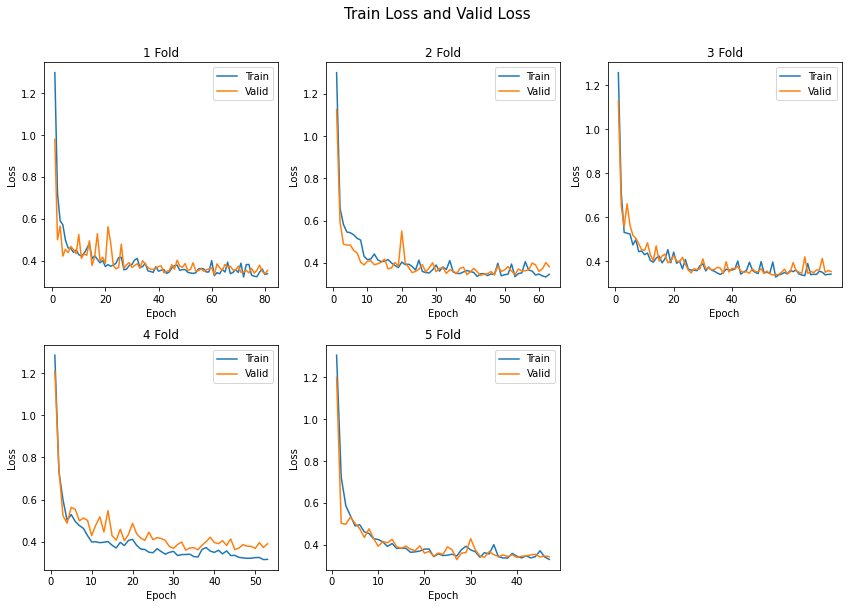

In [84]:
show_loss_plot(fold_train_loss_per_epoch, fold_valid_loss_per_epoch)

## Test 예측

In [102]:
def predict(model, dataloader, weight_save_path, return_prob=False):
    """저장된 모델의 가중치를 불러와서 dataloader의 데이터를 예측하여 반환 """
    model = model.to(device) 
    weight_path_list = glob(weight_save_path + '/*.pt')
    test_probs = np.zeros(shape=(len(dataloader.dataset), NUM_CLASSES))  

    for weight_path in tqdm(weight_path_list):
        if MODEL_NAME not in weight_path:  ## 학습시킨 모델의 가중치만 예측하는데 사용
            continue
            
        probs = None
        model.load_state_dict(torch.load(weight_path, map_location=device))
        model.eval()
        
        with torch.no_grad(): 
            for X in dataloader:  ## test 데이터는 라벨(y)이 없다
                X = X.to(device)
                y_hat = model(X).cpu().numpy()

                if probs is None:
                    probs = y_hat
                else:
                    probs = np.concatenate([probs, y_hat])

        test_probs += (probs / NUM_FOLDS) 
    test_probs = torch.softmax(torch.tensor(test_probs), dim=1)  ## 각 컬럼별 확률
    _, test_preds = torch.max(torch.tensor(test_probs), dim=1)  ## 최댓값과 인덱스

    if return_prob:
        return test_probs  ## 각 컬럼별 확률
    return test_preds  ## 라벨

In [67]:
test_dataloader = get_dataloader(X=test_images, y=None, transforms=get_transforms(train_mode=False), shuffle_dataloader=False)

In [98]:
test_preds = predict(model, test_dataloader, SAVE_PATH, return_prob=False)

  0%|          | 0/5 [00:00<?, ?it/s]

In [99]:
submission['label'] = test_preds
submission.head()

,file_name,label
0,001.PNG,7
1,002.PNG,1
2,003.PNG,9
3,004.PNG,7
4,005.PNG,6


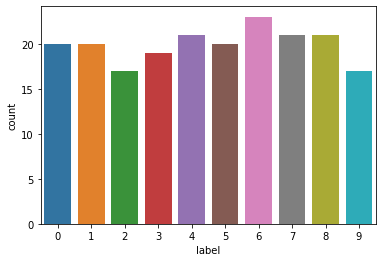

In [100]:
sns.countplot(data=submission, x='label')

In [101]:
# submission.to_csv(f'./Data/submission-{MODEL_NAME}.csv', index=False)